In [1]:
%matplotlib notebook

import pathlib
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wms.dbs import weadbs, hdf5, pit
from wms.analysis import classification, damage, plots
from wms.utils import periods
import bchdf

Using bladecontrol plotting style.
Registering webvis-style.


In [125]:
import importlib
importlib.reload(bchdf.bchdf)
importlib.reload(bchdf)
importlib.reload(hdf5)
importlib.reload(weadbs)
importlib.reload(damage)

<module 'wms.analysis.damage' from 'u:\\wms-python\\wms\\analysis\\damage.py'>

# Damage case Grohnde-Kirchohsen, Vestas 217271 (cmrblba_bc_t_02808)

### necessary information
needed for creating a damage classifier

In [2]:
# database name for the considered turbine
db = 'bc_t_02808'

# the damaged blade
dmg_blade = 2

# the blades without damage throughout the considered period (data_periods below)
# (we usually don't want to compare with data from a different damage case)
ok_blades = [1, 3]

# period in which the damage was present for sure
# as (start, stop)-tuple; unspecified parts of the 
# time stamp string will be filled with 0
# please detail in a comment what the source of this information was
# and why you gave this period, e.g.:
#   - it is unclear from when
#   - it is also unclear until when exactly the large damage existed,
#     the report in the email states that repair was done on 2019-05-05, but the
#     turbine didn't even stand still on that day according to our data;
#     instead turbine stood still 05-06 to 05-09 and from 05-13 to 05-17
#     the last period of stand still was 05-22 to 05-23 which is consistent with
#     the last date in the email report (05-23)
#
# - start: 
#      - in ticket 201912-066 field "Erstauftreten des Fehlers" is filled with 2019-12-7
#      - but data in webAna show increased signal energy of blade 2 already earlier (e.g. 2019-11-29, 15:09:05 CET)
#      - it seems that it didn't occur before 2019-11-27, so "ok"-period should end on this date
#      - maybe it is in increasing effect
#      - effect doesn't occur in every cycle (cf. 2020-1-2, 00:06:15 CET), it seems for rotating with low power 
#        (<200 kW or so) it is hardly noticable or not present, but for standstill and for higher power it occurs in most cycles
#          
# - end: 
#      - field "Lösung" in ticket 201912-066 specifies repair of wtg on 2020-5-19
#      - coincides with graphical history data:
#            - production (with blade damage) until 2020-1-9, 10:46 CET
#            - then idling until 2020-3-31 (pitch ~ 78 deg), except for period Mar 16-19, 2020 (pitch 93.3 deg, 
#              maybe inspection) and some smaller periods on Feb 10, Mar 3 and Mar 11, 2020
#            - stopped from 2020-4-1 (pitch 93.3 deg)
#            - from 2020-5-19 again production with repaired blade, but CMS was in old blade, so no SE data
#            - installation of new CMS (different sensors) on Dec 4, 2020
dmg_period = ('2019-11-29', '2020-05-19')

# the full time period that should be investigated
# use this to restrict data to those periods with comparable 
# measurement conditions, e.g., same installed sensors, same turbine hardware
# also use this to exclude times with otherwise abnormal data, e.g., 
# repair times, or perhaps a different unrelated damage
# you can give several periods in a list
# start: date the wtg became operational
# end: last normal production date after damage and before repair
data_periods = [('2019-04-02', '2020-1-9')]

# periods in which given sensors were defect
# should be a dict with channel names as keys and time periods as values
# this can be as granular as you like, if a sensor was only intermittently
# defect and you can determine the defect times
# according to ticket 201911-281, could not be verified by SE data (missing), af data support this
sens_defects = {'1_edge': ('2019-09-01', '2020-12-04')}

### optional information
these may, or may not be used to create a damage classifier

In [3]:
# period in which the damage may already have been present
dmg_period_uncertain = ('2019-11-27', '2019-11-29')

# status variable regions known to exhibit the damage in measurements
# (excluding status variable regions in which the damage couldn't be seen)
# format see wms.dbs.select.Where
#where = {'power_mean': [(,0), (200,)]}

# sensor orientation which shows the damage most clearly
ori = 'edge'

# normalisation instructions known to result in damage seen in data
# see wms.dbs.weadbs.SEData.normalise for options
normalisation = dict(normhow='div')

# frequency bands in which the damage is seen (if previously identified,
# but this will most likely be ignored during classifier generation)
fbands = np.r_[np.arange(0, 20, 0.2), np.arange(20, 100, 0.5),
               np.arange(100, 200, 1), np.arange(200, 300, 2),
               np.arange(300, 500, 5)]

In [4]:
hdfdir = pathlib.Path(f'D:/damages/V136_Hinterkante/{db}/_current')

## Data conversions

In [8]:
loader = hdf5.HDFSpecs2sda(hdfdir, hdfdir / 'sda_from_specs.h5', 
                           fbands=fbands, min_itemsize={'timezone': 4}, 
                           channels='blades')
_cts = loader.load(('2019', '2020-07'), dt=pd.Timedelta(days=60), verbose=1)

using file bc_t_02808_af_0
loading data for (2018-12-31 23:00:00.000000001+00:00, 2019-03-01 23:00:00.000000001+00:00)
loading data for (2019-03-01 23:00:00.000000001+00:00, 2019-04-30 23:00:00.000000001+00:00)
loading data for (2019-04-30 22:09:03.000000001+00:00, 2019-06-29 22:09:02.000000001+00:00)
loading data for (2019-06-29 20:53:29.000000001+00:00, 2019-08-28 20:53:28.000000001+00:00)
loading data for (2019-08-28 20:06:49.000000001+00:00, 2019-10-27 20:06:48.000000001+00:00)
loading data for (2019-10-27 19:59:05.000000001+00:00, 2019-12-26 19:59:04.000000001+00:00)
loading data for (2019-12-26 19:06:19.000000001+00:00, 2020-02-24 19:06:18.000000001+00:00)
using file bc_t_02808_af_1
loading data for (2019-12-26 20:03:40.000000001+00:00, 2020-02-24 19:06:18.000000001+00:00)
loading data for (2020-02-24 19:03:48.000000001+00:00, 2020-04-24 19:03:47.000000001+00:00)
loading data for (2020-04-24 18:58:17.000000001+00:00, 2020-06-23 18:58:16.000000001+00:00)
loading data for (2020-06-

## Overview over SDA

In [9]:
specsed = weadbs.SEData.from_hdf(hdfdir / 'sda_from_specs.h5', 
                                 where={'omega_mean': (0.05,)})

<IPython.core.display.Javascript object>


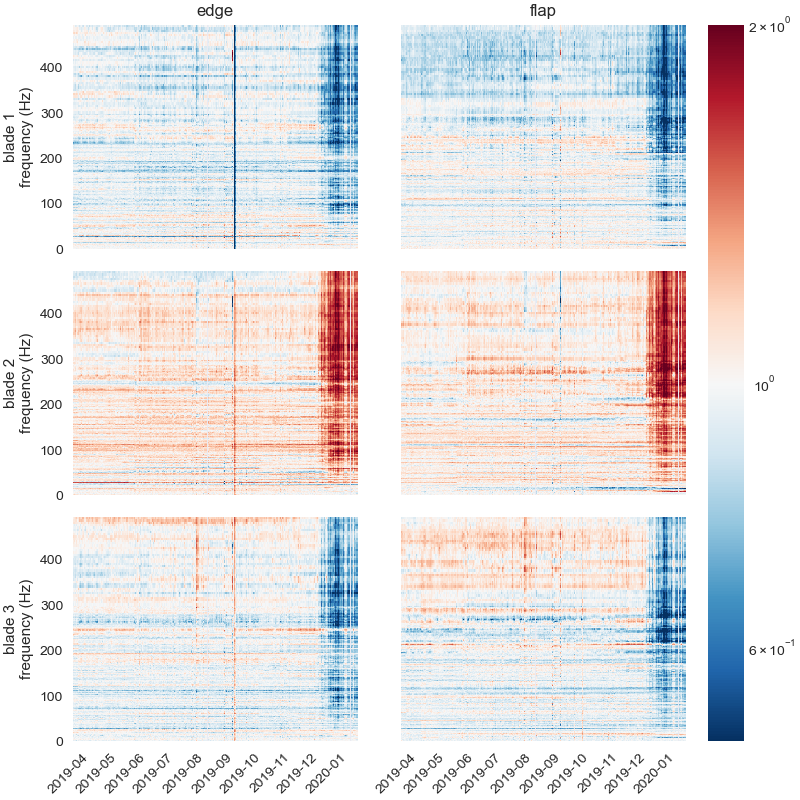

In [10]:
fig, axes = (specsed
             .plot_allse_timecourse(normkws={'normhow': 'div'}, resample='D'))

## BladeDamage class and DI2

In [48]:
dmg_period

('2019-11-29', '2020-05-19')

In [195]:
dmg_blade

2

In [49]:
dmg = damage.BladeDamage(
    db, hdfdir / 'sda_from_specs.h5', dmg_period, dmg_blade, 
    [('2019', '2020-05-19')], sens_defects, scale_by_mpc=False)

### Flap

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


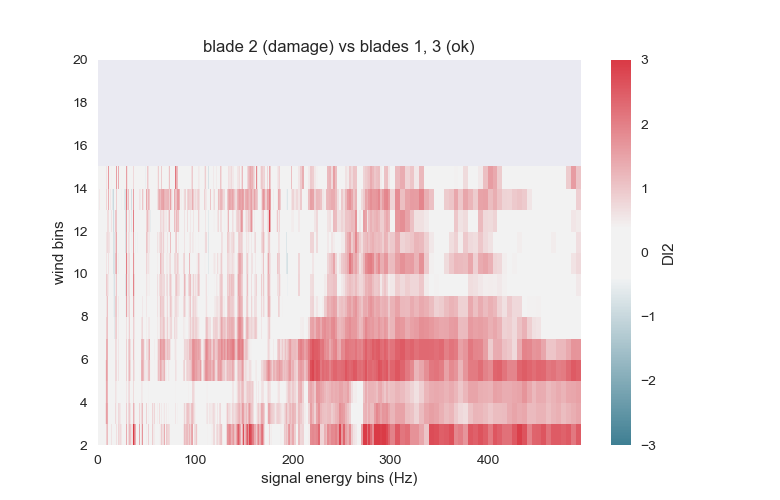

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    dmg.compute_se_DI2_profile(
        'flap', 'wind_mean', vmin=2, vmax=20, vstep=1,
        where={'omega_mean': (0.05,)}, difference_statistic='cohen_d',
        comparison_period='before', show=dict(vmin=0.4, vmax=3))

processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


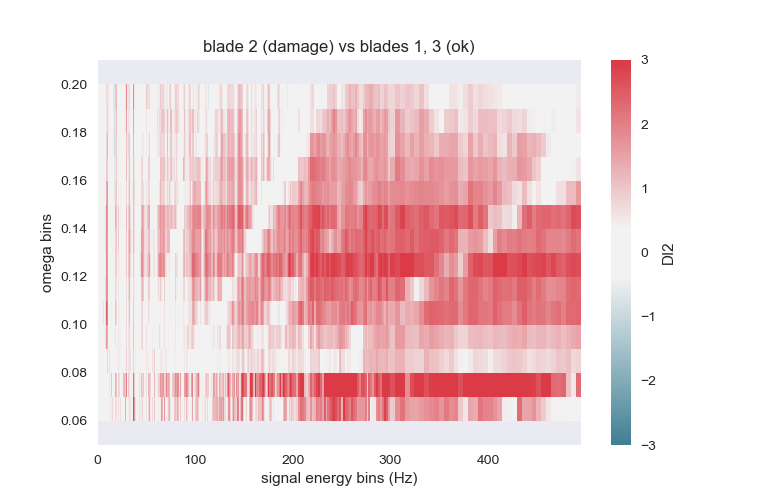

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    dmg.compute_se_DI2_profile(
        'flap', 'omega_mean', vmin=0.05, vmax=0.21, vstep=0.01,
        difference_statistic='cohen_d', comparison_period='before', 
        show=dict(vmin=0.4, vmax=3))

<IPython.core.display.Javascript object>


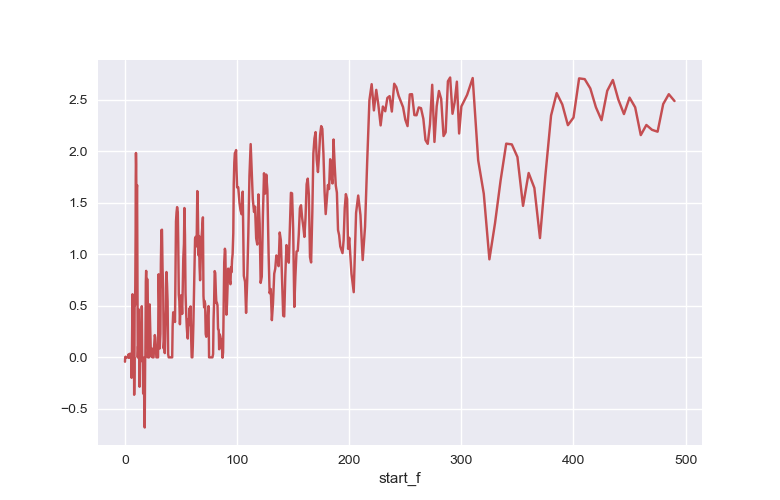

In [50]:
dmg.load_se({'omega_mean': (0.11, 0.13)}, 'flap')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d', comparison_period='before')

plt.figure()
ax = _DI2.plot()

<IPython.core.display.Javascript object>


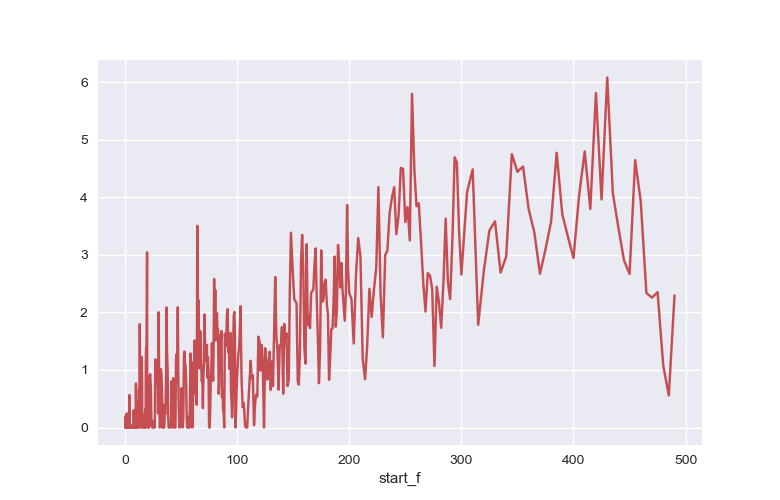

In [51]:
dmg.load_se({'omega_mean': (0.07, 0.08)}, 'flap')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

### Edge

processing wind bin 18 / 18 ...done.


<IPython.core.display.Javascript object>


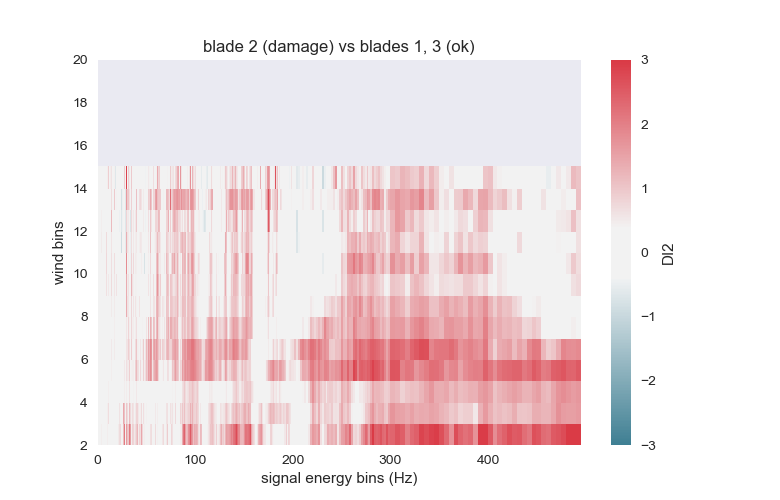

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    dmg.compute_se_DI2_profile(
        'edge', 'wind_mean', vmin=2, vmax=20, vstep=1,
        where={'omega_mean': (0.05,)}, difference_statistic='cohen_d',
        show=dict(vmin=0.4, vmax=3))

processing omega bin 16 / 16 ...done.


<IPython.core.display.Javascript object>


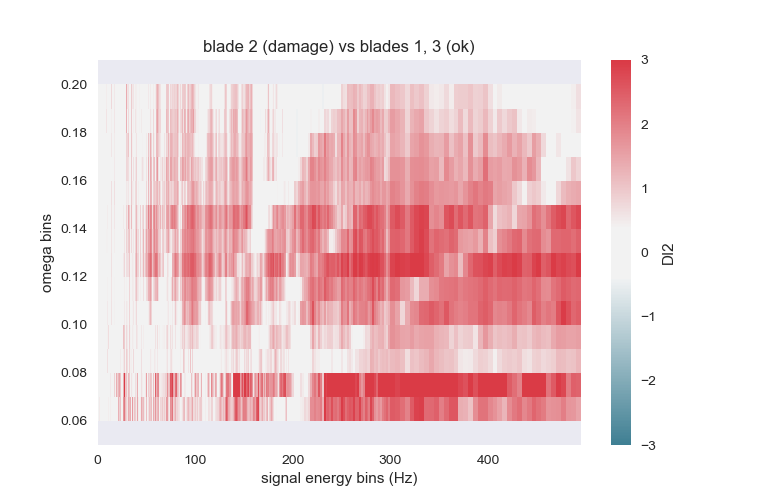

In [54]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    dmg.compute_se_DI2_profile(
        'edge', 'omega_mean', vmin=0.05, vmax=0.21, vstep=0.01,
        difference_statistic='cohen_d', show=dict(vmin=0.4, vmax=3))

u:\wms-python\wms\analysis\damage.py:542: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_edge: damage, 1_edge: after, 2_edge: after, 3_edge: after)
  for ind in nodata])), RuntimeWarning)


<IPython.core.display.Javascript object>


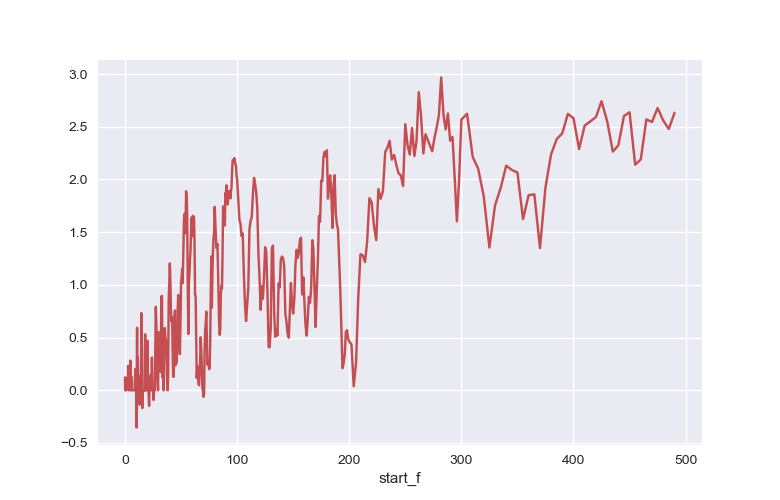

In [55]:
dmg.load_se({'omega_mean': (0.11, 0.13)}, 'edge')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

u:\wms-python\wms\analysis\damage.py:542: RuntimeWarning: There are channels without data in certain periods - subsampling will not work as intended! (1_edge: damage, 1_edge: after, 2_edge: after, 3_edge: after)
  for ind in nodata])), RuntimeWarning)


<IPython.core.display.Javascript object>


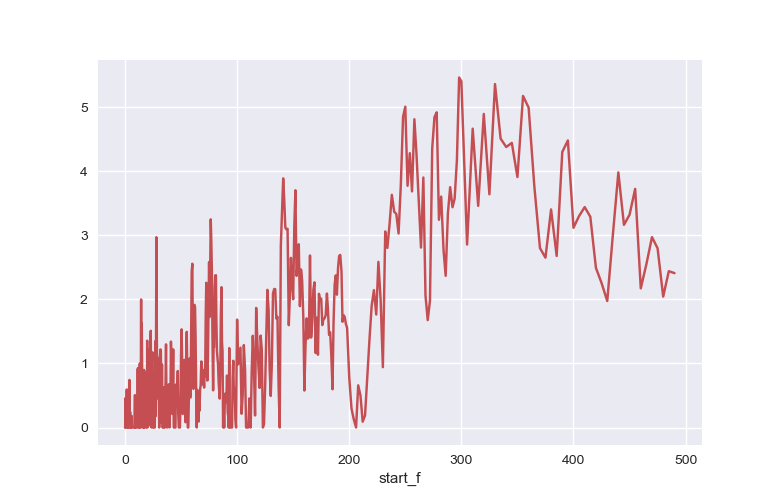

In [56]:
dmg.load_se({'omega_mean': (0.07, 0.08)}, 'edge')
_DI2, _ = dmg.compute_DI2(difference_statistic='cohen_d')

plt.figure()
ax = _DI2.plot()

## Operational state

In [691]:
opstate = {'temperature_mean': (5, ), 'omega_mean': (0.07, 0.08),
           'pitch_mean': (5, 10)}

In [68]:
opstate = {'temperature_mean': (8, 12), 'omega_mean': (0.11, 0.13),
           'pitch_mean': (3.7, 3.9)}

## Normal comparison spectra from other turbines
- properties of this turbine:
    - Vestas V136/3450 Mk3B
    - Getriebe# 271207 (EH922A-C01)
    - Sensorposition 20 m
    - blades: Vestas 67M hybrid
    - sensors: BCA423
- only few other turbines with these properties:

In [137]:
weas = pit.query_pit("""
    SELECT WEA_Name, Datenbankname, Beginn_Datenspeicherung
    FROM VIEW_Windkraftanlagen
    WHERE WEA_Typ#Name = 'Vestas V136/3450 Mk3B'
        AND Datenbankname IS NOT NULL
        AND Sensor_Rotorblatt_1#Sensortyp#Bezeichnung = 'BCA423'
        AND WEA_Typ#Rotorblatt_Typ#Name = 'Vestas 67M hybrid'
        AND Sensorposition_Rotorblatt_1 = 20
        AND Getriebe# = 271207
        """)
weas = weas[~weas.Datenbankname.str.endswith('sim')].set_index('Datenbankname')
weas.index = weas.index.str[8:]
weas.loc[:, 'N_local'] = 0
for _db in weas.index:
    try:
        _loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent.parent / _db)
    except:
        pass
    else:
        weas.loc[_db, 'N_local'] = _loader.Ncycles
weas

,WEA_Name,Beginn_Datenspeicherung,N_local
Datenbankname,,,
bc_t_02395,Vestas 217274,2017-09-06,0
bc_t_02503,Vestas 219447,2018-03-06,0
bc_t_02537,Vestas 219448,2018-03-07,10715
bc_t_02536,Vestas 219449,2018-03-08,0
bc_t_02508,Vestas 219451,2018-03-09,0
bc_t_02507,Vestas 219453,2018-03-12,0
bc_t_02662,Vestas 219944,2018-05-04,0
bc_t_02633,Vestas 219945,2018-05-09,10372
bc_t_02553,Vestas 220015,2018-01-09,0


In [174]:
otherdbs = weas.index[weas.N_local > 0].difference(pd.Index([db]))
otherdbs.name = 'dbname'
otherdbs

Index(['bc_t_02535', 'bc_t_02537', 'bc_t_02561', 'bc_t_02633', 'bc_t_02792',
       'bc_t_02815', 'bc_t_02820', 'bc_t_02826'],
      dtype='object', name='dbname')

- these other turbines have sensor defects or blade/turbine damages:

In [165]:
_db = otherdbs[7]
print(_db)
tickets = pit.get_tickets_for_WEA(
        'cmrblba_' + _db, ['Beginn_am', 'Erstauftreten_des_Fehlers', 'Behebung_des_Fehlers',
             'Titel', 'Lösung', 'Lösungsklasse#Bezeichnung_DE', 'Geschlossen_am'],
        where={'Lösungsklasse#Bezeichnung_DE': {'Kommunikationsanbindung', 'not'},
               'Titel': {'not', 'Externals sind fix', 'Externals sind fix ', 
                         'Externals sind Fix', 'ECU n.e.', 'ECU nicht erreichbar'}})
tickets.iloc[:, [0, -1, 3, 5, 4, 2, 1]]

bc_t_02826


,Erstauftreten_des_Fehlers,Behebung_des_Fehlers,Titel,Lösung,Geschlossen_am,Beginn_am,Lösungsklasse#Bezeichnung_DE
4,2019-10-05,2019-10-25 14:14:00,CMI im Stand über 100,CIM4394 Vestas Blattarbeiten (alle Peaks im St...,2019-10-25 14:14:29.037,2019-10-07,Rotorblätter
5,2019-03-18,2019-10-05 00:00:00,Vertraulich: Blattschaden Trailing Web,None,NaT,2019-10-09,Rotorblatt 1


In [171]:
other_defects = {
    'bc_t_02535': {'3_edge': ('2020-09-06', ),
                   '1_flap': ('2020-09-08 18:00', )},
    'bc_t_02537': {'2_edge': ('2020-09-06 08:00', '2020-12-09'),
                   '2_flap': ('2020-09-06 08:00', '2020-12-09')},
    'bc_t_02561': {'3_edge': ('2020-02-03 22:00', '2020-07-06'),
                   '3_flap': ('2020-02-03 22:00', '2020-07-06')},
    'bc_t_02633': {'1_edge': ('2020-01-21', '2020-03-02'),
                   '1_flap': ('2020-01-21', '2020-03-02'),
                   '2_edge': ('2020-01-21', '2020-03-02'),
                   '2_flap': ('2020-01-21', '2020-03-02'),
                   '2_edge': ('2020-01-21', '2020-03-02'),
                   '2_flap': ('2020-01-21', '2020-03-02')},
    'bc_t_02792': {'1_edge': ('2020-05-06', '2020-12-04 13'),
                   '1_flap': ('2020-05-06', '2020-12-04 13'),
                   '2_edge': ('2020-05-06', '2020-12-04 13'),
                   '2_flap': ('2020-05-06', '2020-12-04 13'),
                   '2_edge': ('2020-05-06', '2020-12-04 13'),
                   '2_flap': ('2020-05-06', '2020-12-04 13')},
    'bc_t_02815': {'1_flap': ('2019-01-21', '2019-05-19')},
    'bc_t_02820': {},
    'bc_t_02826': {'1_edge': ('2019-03-18', '2019-10-05'),
                   '1_flap': ('2019-03-18', '2019-10-05')}}

In [166]:
stvars = ['azimuth_mean', 'azimuth_sigma', 'omega_mean', 'omega_sigma', 'pitch_mean', 'pitch_sigma', 'power_mean', 'power_sigma',
          'temperature_mean', 'wind_mean', 'wind_sigma']

In [167]:
otherst = []
for _db in otherdbs:
    _where = opstate.copy()
    _where['create_time'] = ('2019-03', '2020-06-05')
    otherst.append(
        weadbs.cdef_query(
            _db, cycle='hour', columns=['create_time'] + stvars, where=_where)
        .set_index('create_time'))
    
otherst = pd.concat(otherst, keys=otherdbs)

In [172]:
ospecs = []
for _db in otherdbs:
    _loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent.parent / _db)
    ospec, _, _ = _loader.load(('2019', '2020-07'), channels='blades')
    _st = otherst.loc[_db]
    _st.index = _st.index.tz_localize(_loader.origin_tz)
    osed = weadbs.SEData(ospec.astype(float), _st.loc[ospec.index])
    osed.convert_channel_names('{blade}_{ori}')
    
    # set data with defects to NaN
    for _ch, _period in other_defects[_db].items():
        sl = slice(*_period) if len(_period) == 2 else slice(_period[0], None)
        osed.se.loc[sl, _ch] = np.nan
        
    ospecs.append(osed)
    
ospecs = weadbs.SEData.concat(ospecs, otherdbs)

loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.
loading ... 100% done.
combining data ... done.


In [180]:
omeans = ospecs.se.groupby(level='dbname').mean().stack('channel').T

## Find peaks in spectrogram

In [184]:
loader = hdf5.FilterLoader(opstate, 'af', hdfdir.parent, filterfirst=True)

specs, _ticks, _cts = loader.load(('2019', '2019-11-27'), channels='blades')
st = weadbs.cdef_query(
    db, cycle='hour', where={'create_time': set(specs.index)})
st.set_index('create_time', inplace=True)
st.index = st.index.tz_localize(loader.origin_tz)

specs = weadbs.SEData(specs, st)
specs.convert_channel_names('{blade}_{ori}')
specs

loading ... 100% done.
combining data ... done.


signal energies for channels:
[1_edge, 1_flap, 2_edge, 2_flap, 3_edge, 3_flap]
from 2019-03-23 23:03:31+01:00 to 2019-11-26 22:02:49+01:00
100 rows

In [185]:
specs_dmg, _ticks, _cts = loader.load(('2019-11-29', '2020'), channels='blades')

_st = weadbs.cdef_query(
    db, cycle='hour', where={'create_time': set(specs_dmg.index)})
_st.set_index('create_time', inplace=True)
_st.index = _st.index.tz_localize(loader.origin_tz)

specs_dmg = weadbs.SEData(specs_dmg, _st)
specs_dmg.convert_channel_names('{blade}_{ori}')
specs_dmg

loading ... 100% done.
combining data ... done.


signal energies for channels:
[1_edge, 1_flap, 2_edge, 2_flap, 3_edge, 3_flap]
from 2019-11-29 00:08:52+01:00 to 2019-12-30 21:29:29+01:00
47 rows

<IPython.core.display.Javascript object>


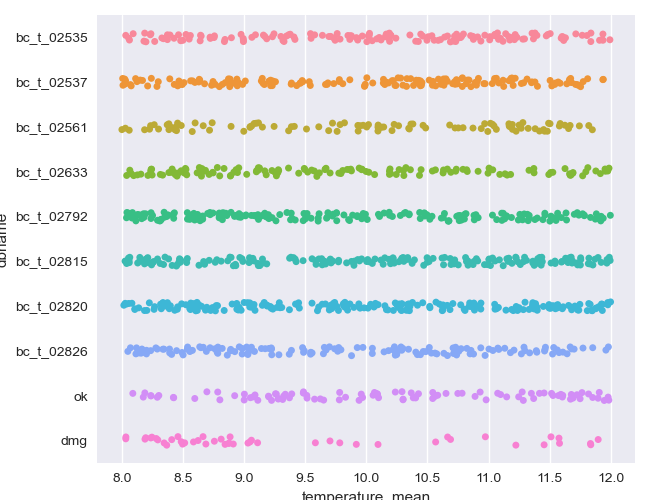

In [188]:
_stvar = 'temperature_mean'
_data = pd.concat(
    [ospecs.st[_stvar], pd.concat([specs.st[_stvar]], keys=['ok']),
     pd.concat([specs_dmg.st[_stvar]], keys=['dmg'])])

fg = sns.catplot(data=_data.reset_index(), y='dbname', x=_stvar, aspect=1.3)

<IPython.core.display.Javascript object>


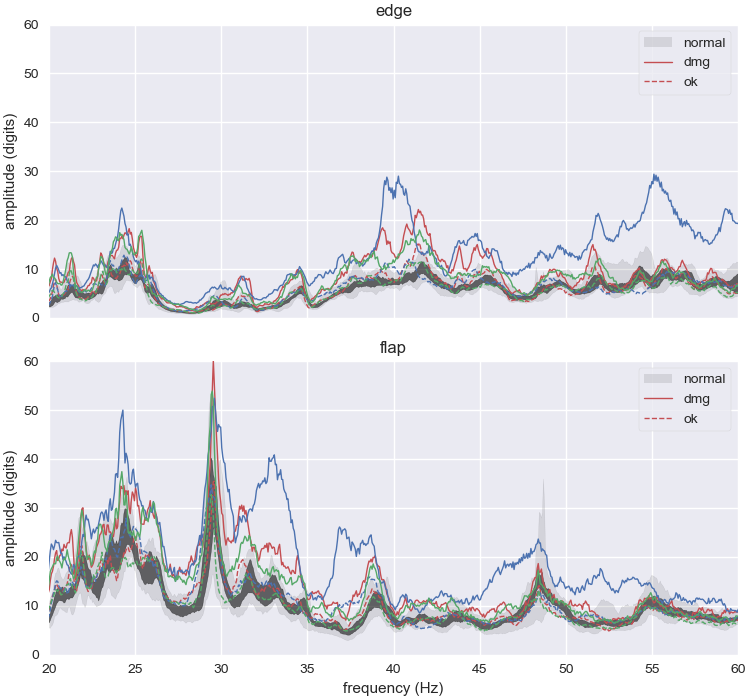

In [189]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True,
                         constrained_layout=True, figsize=(7.5, 7))

for ax, _ori in zip(axes, ('edge', 'flap')):
    ax = plots.quantileband(
        omeans.loc[:, omeans.columns.get_level_values('channel')
                   .str.endswith(_ori)],
        mean=False, color='k', ax=ax)

    mok = specs.select_channels(_ori).se.mean().unstack('channel')
    mdmg = specs_dmg.select_channels(_ori).se.mean().unstack('channel')
    for bl in range(1, 4):
        _ch = specs.info['chform'].format(blade=bl, ori=_ori)
        _ = ax.plot(mok.index, mok[_ch], color=f'C{bl - 1}', lw=1, ls='--', label='ok')
        _ = ax.plot(mdmg.index, mdmg[_ch], color=f'C{bl - 1}', lw=1, label='dmg')
        
    _band = ax.get_children()[0]
    _handles = [
        plt.matplotlib.patches.Patch(facecolor=_band.get_fc()[0], label='normal'),
        plt.matplotlib.lines.Line2D([0], [0], lw=1, color='C0', label='dmg'),
        plt.matplotlib.lines.Line2D([0], [0], lw=1, color='C0', ls='--', label='ok')]
    
    ax.legend(handles=_handles)
    ax.set_title(_ori)
    ax.set_ylabel(f"amplitude ({specs.info['units']})")
    
_ = ax.set_xlabel('frequency (Hz)')

In [197]:
_ = ax.set_xlim(20, 80)
_ = ax.set_ylim(0, 60)

In [198]:
_ = ax.set_xlim(20, 60)
_ = ax.set_ylim(0, 60)

In [190]:
_ = axes[-1].set_xlim(0, 10)
_ = axes[-1].set_ylim(0, 200)

In [194]:
_ = axes[-1].set_xlim(5, 20)
_ = axes[-1].set_ylim(0, 100)